In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

image_size = (224, 244)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Elbrus/Skin Cancer Malignant vs. Benign/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Elbrus/Skin Cancer Malignant vs. Benign/test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2637 files belonging to 2 classes.
Using 2110 files for training.
Found 660 files belonging to 2 classes.
Using 132 files for validation.


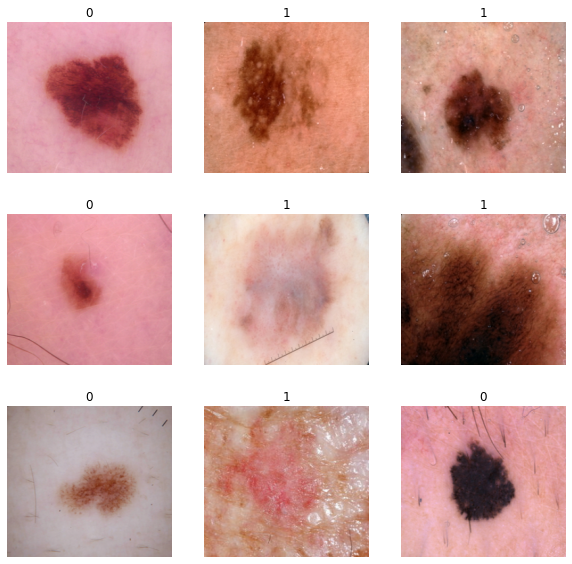

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# size = (224, 244)

# train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
# val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, size), y))
# test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))


In [ ]:
# batch_size = 32

# train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
# val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=10)
# test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)


In [ ]:

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.5),
        layers.experimental.preprocessing.RandomTranslation(.1, .1)
    ]
)


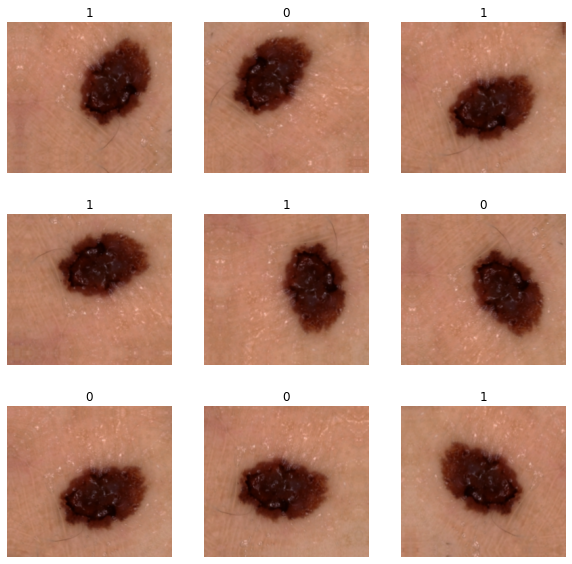

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 224, 244, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 244, 3)       0         
_________________________________________________________________
normalization_21 (Normalizat (None, 224, 244, 3)       7         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_max_pooling2d_4 (Glob (None, 1920)              0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 1920)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 192

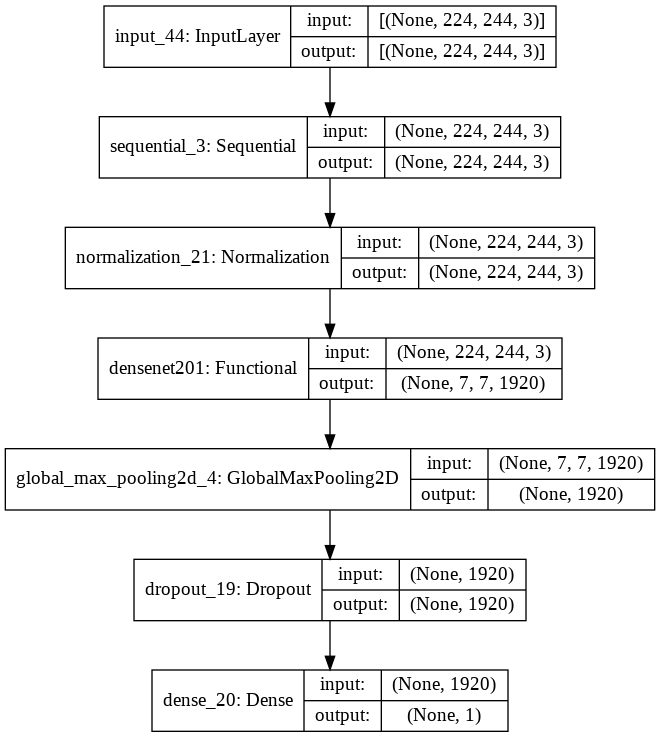

In [99]:
base_model = keras.applications.DenseNet201(
    weights="imagenet",  # Берем веса, полученные на ImageNet.
    input_shape=(224, 244, 3),
    include_top=False,
)  # Отключаем дефолтный классификатор .

# Указываем, что тренировать Xception не надо
base_model.trainable = False

# Делаем свой входной плейсхолдер
inputs = keras.Input(shape=(224, 244, 3))
x = data_augmentation(inputs)  # Применяем аугментацию


norm_layer = keras.layers.experimental.preprocessing.Normalization( )
mean = np.array([127.5, 127.5, 127.5])
var = mean ** 2

# Стандартизируем
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# Добавляем слой пулинга и дропаута
x = base_model(x, training=False)
# x = layers.Conv2D(64, 3, padding="same")(x)
# x = layers.MaxPooling2D()(x)
x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Dropout(0.02)(x)  
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [96]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 50
results = model.fit(train_ds, 
                    epochs=epochs, 
                    validation_data=test_ds)


Epoch 1/50
66/66 [==============================] - 28s 280ms/step - loss: 0.6258 - binary_accuracy: 0.6919 - val_loss: 0.6213 - val_binary_accuracy: 0.7955
Epoch 2/50
66/66 [==============================] - 16s 236ms/step - loss: 0.4739 - binary_accuracy: 0.7725 - val_loss: 0.4821 - val_binary_accuracy: 0.8030
Epoch 3/50
66/66 [==============================] - 16s 233ms/step - loss: 0.4070 - binary_accuracy: 0.7972 - val_loss: 0.4785 - val_binary_accuracy: 0.7879
Epoch 4/50
66/66 [==============================] - 16s 230ms/step - loss: 0.3865 - binary_accuracy: 0.8062 - val_loss: 0.4714 - val_binary_accuracy: 0.7803
Epoch 5/50
66/66 [==============================] - 16s 237ms/step - loss: 0.3663 - binary_accuracy: 0.8185 - val_loss: 0.4565 - val_binary_accuracy: 0.8030
Epoch 6/50
66/66 [==============================] - 16s 240ms/step - loss: 0.3709 - binary_accuracy: 0.8175 - val_loss: 0.4743 - val_binary_accuracy: 0.8030
Epoch 7/50
66/66 [==============================] - 16s 23

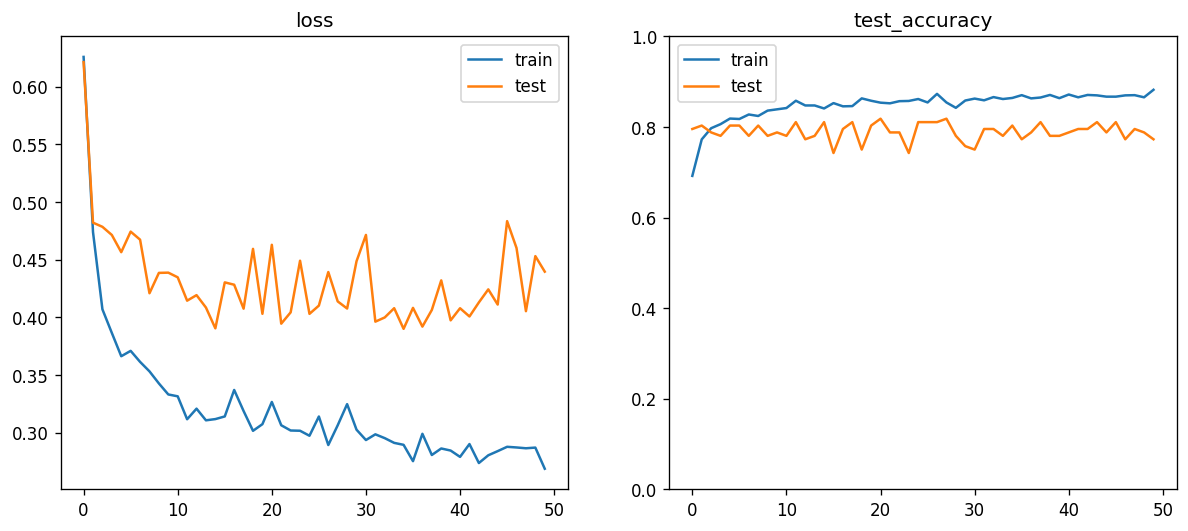

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

ax1.plot(results.history['loss'], label='train')
ax1.plot(results.history['val_loss'], label='test')
ax1.set_title('loss')
ax1.legend()

ax2.plot(results.history['binary_accuracy'], label='train')
ax2.plot(results.history['val_binary_accuracy'], label='test')
ax2.set_ylim([0, 1])
ax2.set_title('test_accuracy')
ax2.legend()

In [94]:
model.evaluate(test_ds)

5/5 [==============================] - 1s 129ms/step - loss: 0.3996 - binary_accuracy: 0.8258


[0.39956218004226685, 0.8257575631141663]

In [98]:
model.evaluate(test_ds)

5/5 [==============================] - 1s 134ms/step - loss: 0.4396 - binary_accuracy: 0.7727


[0.4396307170391083, 0.7727272510528564]